In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.groundtruth_keypoint_dataset import GroundTruthKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver')
keypoint_2d_path = dataset_root_path / 'annotations'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/'


train_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)
val_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)
test_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs


train_dataset 37499 val_dataset 6250 test_dataset 6251


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 4032.7510833740234


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 2925 batches: 333.6995277980454
val MPJPE from: 6208 samples : 49.215298146009445


Validation: 0it [00:00, ?it/s]

check #2
training loss from 2925 batches: 79.06400311324332
val MPJPE from: 6208 samples : 46.44310474395752


Validation: 0it [00:00, ?it/s]

check #3
training loss from 2925 batches: 64.29472785220187
val MPJPE from: 6208 samples : 37.60095313191414


Validation: 0it [00:00, ?it/s]

check #4
training loss from 2925 batches: 58.943451180672035
val MPJPE from: 6208 samples : 38.45233470201492


Validation: 0it [00:00, ?it/s]

check #5
training loss from 2925 batches: 55.16420074380361
val MPJPE from: 6208 samples : 35.012386739254


Validation: 0it [00:00, ?it/s]

check #6
training loss from 2925 batches: 52.53177353841627
val MPJPE from: 6208 samples : 34.090060740709305


Validation: 0it [00:00, ?it/s]

check #7
training loss from 2925 batches: 50.03345715184497
val MPJPE from: 6208 samples : 33.82699564099312


Validation: 0it [00:00, ?it/s]

check #8
training loss from 2925 batches: 48.52983921638921
val MPJPE from: 6208 samples : 35.43916717171669


Validation: 0it [00:00, ?it/s]

check #9
training loss from 2925 batches: 47.20285425965603
val MPJPE from: 6208 samples : 32.562948763370514


Validation: 0it [00:00, ?it/s]

check #10
training loss from 2925 batches: 45.940726074652794
val MPJPE from: 6208 samples : 31.64568543434143


Validation: 0it [00:00, ?it/s]

check #11
training loss from 2925 batches: 45.215235367799416
val MPJPE from: 6208 samples : 31.99594095349312


Validation: 0it [00:00, ?it/s]

check #12
training loss from 2925 batches: 44.27477266543951
val MPJPE from: 6208 samples : 33.27125310897827


Validation: 0it [00:00, ?it/s]

check #13
training loss from 2925 batches: 43.66279895998474
val MPJPE from: 6208 samples : 32.590582966804504


Validation: 0it [00:00, ?it/s]

check #14
training loss from 2925 batches: 43.184166290821175
val MPJPE from: 6208 samples : 31.690463423728943


Validation: 0it [00:00, ?it/s]

check #15
training loss from 2925 batches: 42.68485700854888
val MPJPE from: 6208 samples : 32.40404278039932


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs/version_0/checkpoints/epoch=49-step=29250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs/version_0/checkpoints/epoch=49-step=29250.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 30.57508376809249
PJPE
                     PJPE
nose            21.801615
left_eye        22.493043
right_eye       23.391952
left_ear        20.553523
right_ear       20.987147
left_shoulder   23.330649
right_shoulder  24.362705
left_elbow      76.891688
right_elbow     57.100187
left_wrist      36.687132
right_wrist     39.186288
left_hip        19.679369
right_hip       11.010790
activities_mpjpe:
{}
test mpjpe: 30.57508376809249


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     30.57508376809249     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 30.57508376809249}]

In [4]:
trainer.model.test_history[0]['pjpe']

,PJPE
nose,21.801615
left_eye,22.493043
right_eye,23.391952
left_ear,20.553523
right_ear,20.987147
left_shoulder,23.330649
right_shoulder,24.362705
left_elbow,76.891688
right_elbow,57.100187
left_wrist,36.687132


In [5]:
trainer.model.test_history[0]['mpjpe']

30.57508376809249

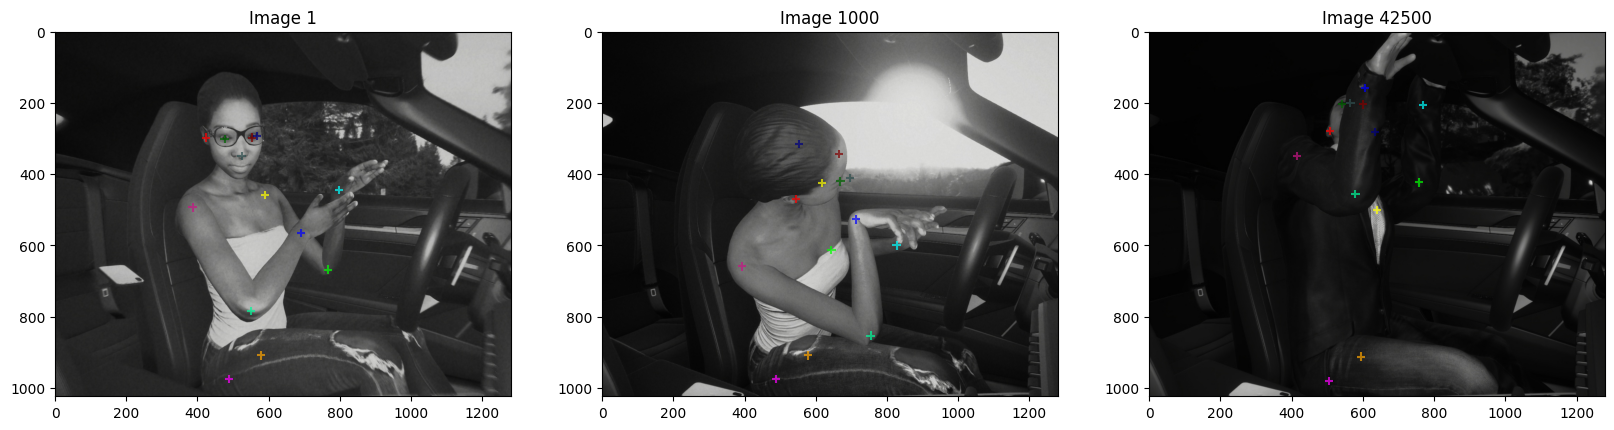

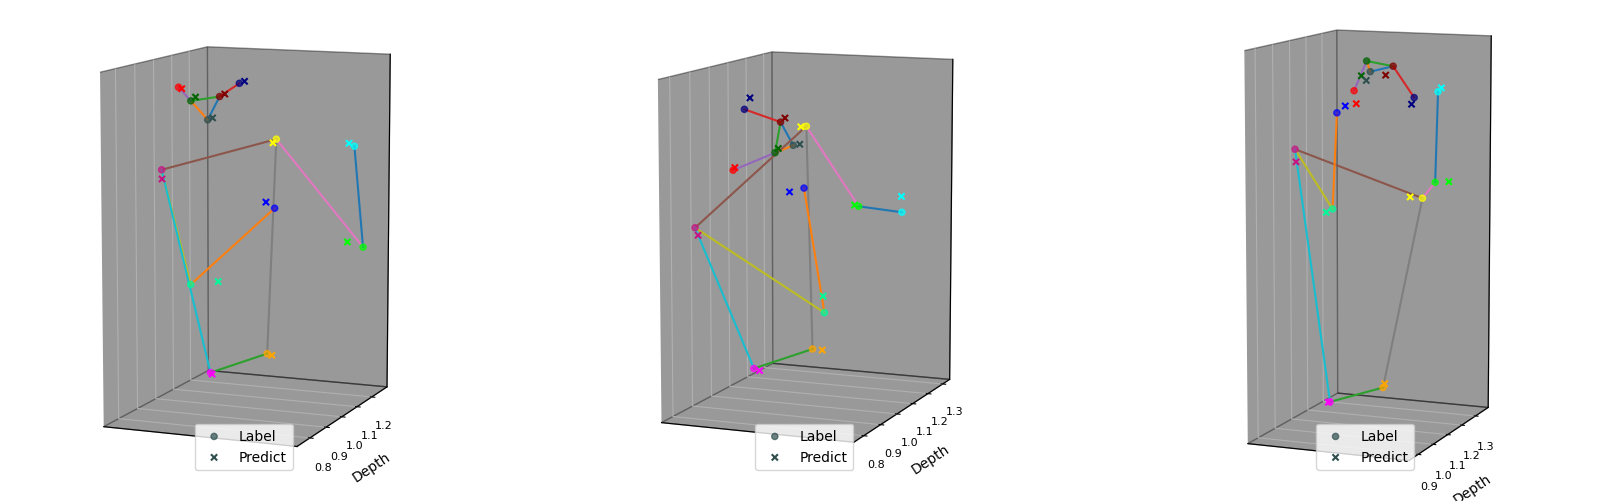

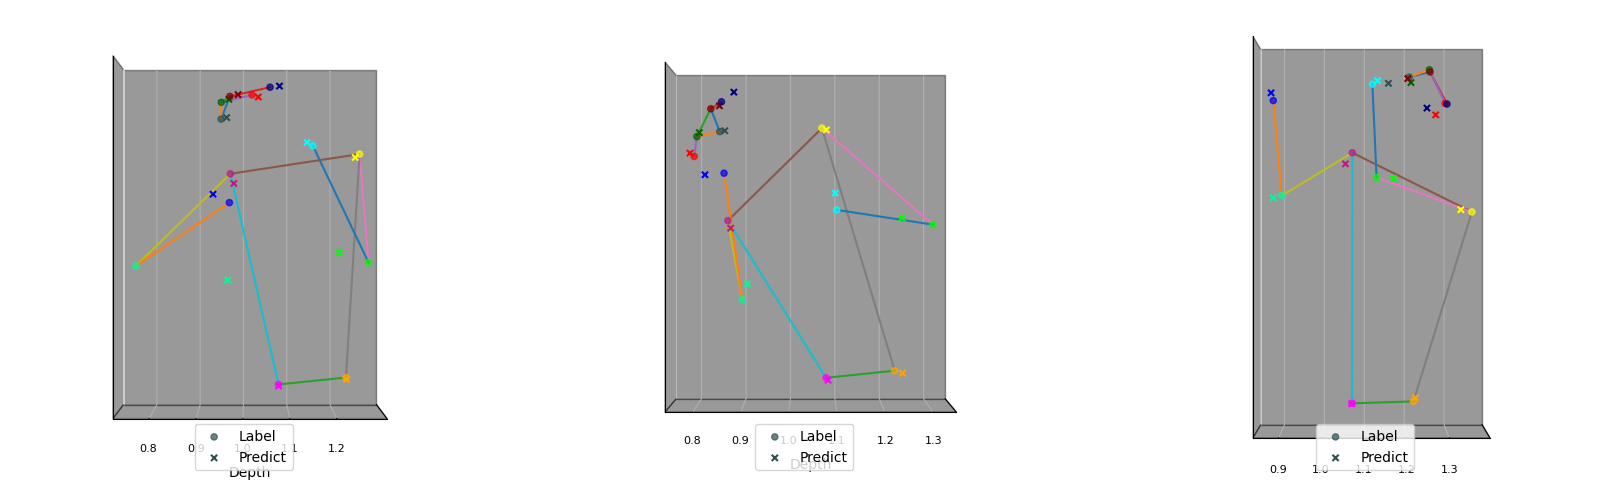

In [7]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'test',
    img_figsize=(20, 10),
    img_width=image_width,
    img_height=image_height,
    plot_figsize=(20.5, 10),
    sample_idices=[1, 1000, 5000]
)